# Volume and Face Vertical Area: Directly from RAS Ouptut

We discovered that face vertical area and cell volume can be printed directly to HDF output. This notebook is for figuring out how to integrate those outputs. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, '../')

In [3]:
import ras2dwq as wq

In [8]:
test_mesh = wq.main('../data/BoxModel.p02.hdf', 0.1, testing=True)

Setting up mesh...
 Configuring geometry...
 Populating results...
Computing values...
<KeysViewHDF5 ['Boundary Conditions', 'Cell Courant', 'Cell Divergence Term', 'Cell Eddy Viscosity - Eddy Viscosity X', 'Cell Eddy Viscosity - Eddy Viscosity Y', 'Cell Flow Balance', 'Cell Hydraulic Depth', 'Cell Invert Depth', 'Cell Storage Term', 'Cell Velocity - Velocity X', 'Cell Velocity - Velocity Y', 'Cell Volume', 'Cell Volume Error', 'Cell Water Source Term', 'Cell Water Surface Error', 'Face Courant', 'Face Cumulative Volume', 'Face Eddy Viscosity', 'Face Flow', 'Face Flow Period Average', 'Face Friction Term', 'Face Pressure Gradient Term', 'Face Shear Stress', 'Face Tangential Velocity', 'Face Velocity', 'Face Water Surface', 'Log Hydraulics', 'Node Velocity - Velocity X', 'Node Velocity - Velocity Y', 'Time Step', 'Water Surface']>


## Volume Comparison

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.scatter(test_mesh.volume[t], test_mesh.volume_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_xlabel('Volume (HDF Output)')
    ax.set_ylabel('Volume (Calculated)')
    for i, txt in enumerate(test_mesh.volume[t]):
        ax.annotate(i, (test_mesh.volume[t][i].values, test_mesh.volume_archive[t][i].values))
    fig.set_size_inches(10,5)
    plt.show()

The first noticeable difference is that the HDF output calculates a volume for ghost cells. This appears to be positive in the case of cells receiving flow (15, 16, 19), negative for those giving flow, and 0 for those not giving/receiving any flow. This will be useful for some of our calculations.

The calculated vs printed values look pretty similar for real cells! Let's just print those now to see how close our calculated values were:

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.plot(range(0,9), test_mesh.volume[t][0:9] - test_mesh.volume_archive[t][0:9])
    ax.set_title(f'time = {t}')
    ax.set_ylabel('Real Volume - Calculated Volume')
    ax.set_xlabel('Cell #')
    plt.show()

The vaues we calculated were actually quite similar to those printed in the HDF output. 

## Flow Across Face

Users are able to optionally print this to a RAS HDF output file. We previously had calculated the flow across the face by multiplying the velocity by the face vertical area. 

Let's compare those calculated values to the values output by RAS:

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.scatter(test_mesh.edge_vertical_area[t], test_mesh.edge_vertical_area_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_xlabel('Flow Across Face (HDF Output)')
    ax.set_ylabel('Flow Across Face (Calculated)')
    for i, txt in enumerate(test_mesh.advection_coeff[t]):
        ax.annotate(i, (test_mesh.edge_vertical_area[t][i].values, test_mesh.edge_vertical_area_archive[t][i].values))
    fig.set_size_inches(10,5)
    plt.show()

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.plot(test_mesh.nedge, test_mesh.edge_vertical_area[t] - test_mesh.edge_vertical_area_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_ylabel('Real Flux - Calculated Flux')
    ax.set_xlabel('Edge #')
    plt.show()

## Error Messages 

In [ ]:
error_mesh = wq.main('../../tests/input_files/Box-Model/BoxModel.p01.hdf', 0.1, testing=True)

Found that when the items are missing (i.e., not printed to the output file) then there is a KeyError. Added an exception to print warning messages for now so that we don't create errors in all of our example notebooks. We can flush this out more (make flow across face calcs more accurate; better error messages). 

## Adjust Sparse Matrix Framework

### Advection Coefficient

Had to adjust the sparse matrix calculation to multiply by negative 1 where the edge velocity is negative, since the flow across the face in RAS does not have a sign. 

Here we test to confirm that everything is still going the way we expect:

In [9]:
input_arr = np.zeros((len(test_mesh['time']), len(test_mesh['nface'])))
input_arr[0][0] = 50

In [10]:
%%time
solved_mesh = wq.wq_simulation(test_mesh, input_arr)

Starting WQ Simulation...
 25%
 50%
 75%
 100%
CPU times: total: 219 ms
Wall time: 217 ms


<xarray.DataArray 'load' ()>
array(83.33133062)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:00:00
<xarray.DataArray 'load' (nface: 21)>
array([83.33133062,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])
Coordinates:
    time     datetime64[ns] 2022-01-01T12:00:00
    face_x   (nface) float64 1.641e+06 1.641e+06 ... 1.641e+06 1.642e+06
    face_y   (nface) float64 6.69e+05 6.69e+05 6.69e+05 ... 6.689e+05 6.689e+05
Dimensions without coordinates: nface
Attributes:
    Units:    ft3
<xarray.DataArray 'load' ()>
array(12.38487869)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:01:00
<xarray.DataArray 'load' (nface: 21)>
array([3.90333463, 1.23398698, 0.27205758, 2.19583163, 1.31671675,
       0.39023985, 1.35949992, 1.26018219, 0.453

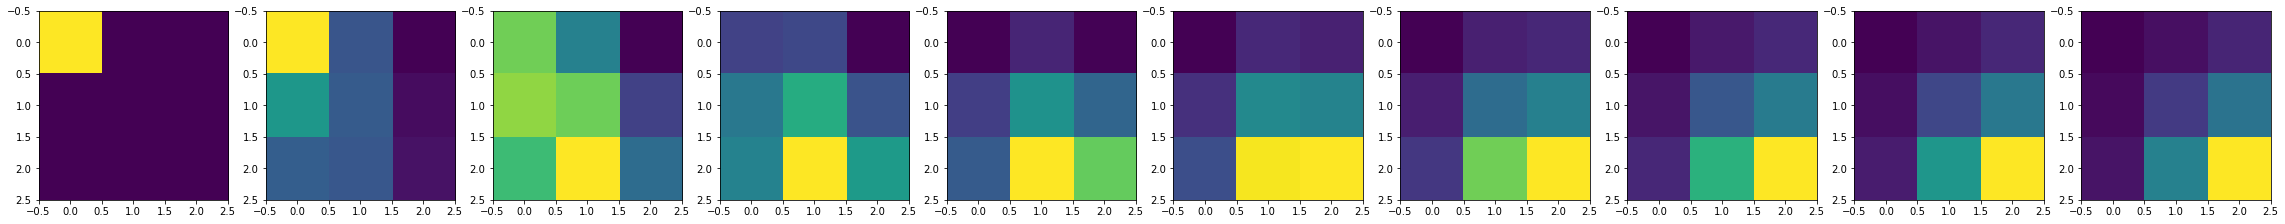

In [11]:
fig, ax = plt.subplots(1,10)
for t in range(len(solved_mesh['time']) - 1):
    ax[t].imshow(solved_mesh['load'][t].values[0:9].reshape(3,3))
    print(solved_mesh['load'][t].sum())
    print(solved_mesh['load'][t])
fig.set_size_inches(40,5)

In [10]:
solved_mesh.edge_vertical_area_archive

<xarray.DataArray 'edge_vertical_area_archive' (time: 11, nedge: 24)>
array([[10.0000248 , 10.0000248 , 10.0000248 , 10.0000248 , 10.0000248 ,
        10.0000248 , 12.07077408, 10.0000248 , 10.0000248 , 10.0000248 ,
        10.0000248 , 12.07077408, 10.0000248 , 10.0000248 , 10.0000248 ,
        11.69347   , 11.69347   , 10.0000248 , 11.69347   , 12.07077408,
        10.0000248 , 12.07077408, 10.0000248 , 11.69347   ],
       [16.32387733, 16.32387733, 16.32387733, 15.93264198, 15.93264198,
        15.93264198, 18.93055916, 15.68300819, 14.63259315, 14.63259315,
        14.63259315, 17.29499626, 14.32802773, 15.18007851, 15.18007851,
        15.16424656, 15.16424656, 12.3260746 , 14.41342258, 14.54548359,
        16.32387733, 18.93055916, 12.96816444, 14.09082508],
       [16.26772499, 16.26772499, 16.26772499, 15.92592812, 15.92592812,
        15.92592812, 18.95929146, 15.7068119 , 14.77419472, 14.77419472,
        14.77419472, 17.50496674, 14.50197792, 15.26247597, 15.26247597,
        15.43402958, 15.43402958, 12.58303261, 14.71389484, 14.87333202,
        16.26772499, 18.95929146, 13.19887733, 14.40842724],
       [16.26711464, 16.26711464, 16.26711464, 15.92470741, 15.92470741,
        15.92470741, 18.95855522, 15.70620155, 14.77358437, 14.77358437,
        14.77358437, 17.50496674, 14.50197792, 15.26186562, 15.26186562,
        15.43402958, 15.43402958, 12.58242226, 14.7131815 , 14.87333202,
        16.26711464, 18.95855522, 13.19887733, 14.40842724],
...
       [16.26711464, 16.26711464, 16.26711464, 15.92470741, 15.92470741,
        15.92470741, 18.95855522, 15.70620155, 14.77358437, 14.77358437,
        14.77358437, 17.50496674, 14.50197792, 15.26186562, 15.26186562,
        15.43402958, 15.43402958, 12.58242226, 14.7131815 , 14.87333202,
        16.26711464, 18.95855522, 13.19887733, 14.40842724],
       [16.26711464, 16.26711464, 16.26711464, 15.92470741, 15.92470741,
        15.92470741, 18.95855522, 15.70620155, 14.77358437, 14.77358437,
        14.77358437, 17.50496674, 14.50197792, 15.26186562, 15.26186562,
        15.43402958, 15.43402958, 12.58242226, 14.7131815 , 14.87333202,
        16.26711464, 18.95855522, 13.19887733, 14.40842724],
       [16.26711464, 16.26711464, 16.26711464, 15.92470741, 15.92470741,
        15.92470741, 18.95855522, 15.70620155, 14.77358437, 14.77358437,
        14.77358437, 17.50496674, 14.50197792, 15.26186562, 15.26186562,
        15.43402958, 15.43402958, 12.58242226, 14.7131815 , 14.87333202,
        16.26711464, 18.95855522, 13.19887733, 14.40842724],
       [16.26711464, 16.26711464, 16.26711464, 15.92470741, 15.92470741,
        15.92470741, 18.95855522, 15.70620155, 14.77358437, 14.77358437,
        14.77358437, 17.50496674, 14.50197792, 15.26186562, 15.26186562,
        15.43402958, 15.43402958, 12.58242226, 14.7131815 , 14.87333202,
        16.26711464, 18.95855522, 13.19887733, 14.40842724]])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-01-01T12:10:00
Dimensions without coordinates: nedge
Attributes:
    Units:    ft